In [1]:
%matplotlib inline
from preamble import *

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import plotting as pl

import cPickle

### Read in the data

In [2]:
data = pd.read_csv('data/higgs_data.csv')

higgs_85 = pd.read_csv('data/higgs_higgs_85.csv')
higgs_90 = pd.read_csv('data/higgs_higgs_90.csv')
higgs_95 = pd.read_csv('data/higgs_higgs_95.csv')
eeqq = pd.read_csv('data/higgs_eeqq.csv')
qq = pd.read_csv('data/higgs_qq.csv')
wen = pd.read_csv('data/higgs_wen.csv')
ww = pd.read_csv('data/higgs_ww.csv')
zee = pd.read_csv('data/higgs_zee.csv')
zz = pd.read_csv('data/higgs_zz.csv')


framesMC_NoHiggs = [qq, ww, zz, zee, wen, eeqq]
framesMC_NoHiggsNames = ['qq', 'ww', 'zz', 'zee', 'wen', 'eeqq']

framesMC_HiggsModels = [higgs_85, higgs_90, higgs_95]
framesMC_HiggsModelsNames = ['higgs_85', 'higgs_90', 'higgs_95']

<img src="samples_full.png"> 

### Load the BDT from sig-bkg classification

In [3]:
with open('BDT_85higgs1.pkl', 'rb') as fid:
    gnb_loaded = cPickle.load(fid)
gnb_loaded.get_params

<bound method GradientBoostingClassifier.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)>

In [4]:
def PickDiscVar_mH85 (df) :
    discriminating_vars = [u'btag1', u'btag2',
       u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis', u'fth1',
       u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi']
    return df[discriminating_vars]

### Introduce weights in order to rescale all the MC samples to the same luminosity

per definition the weight of each measured event (data) is $1$. Thus, we want to rescale the MC to the same ntegrated Luminosity of the data taking which is $L = 176.773 \ \mathrm{pb}^{-1}$

The weight for each MC sample is:
$$ 
        \mathrm{weight}_\mathrm{MC} = L \cdot  \frac{\sigma_\mathrm{MC} }{N_\mathrm{MC}}
$$

In [5]:
crossSectionsMC_noHiggs = [102., 16.5, 0.975, 3.35, 2.9, 15600.]
NumberMC_noHiggs = [200000., 294500., 196000., 29500., 81786., 5940000.]

crossSectionsMC_HiggsModels = [0.094, 0.0667, 0.0333]
NumberMC_HiggsModels = [3972., 3973., 3971.]


Lum = 176.773


weightsMC_noHiggs     = Lum*np.array(crossSectionsMC_noHiggs) / np.array(NumberMC_noHiggs) 
weightsMC_HiggsModels = Lum*np.array(crossSectionsMC_HiggsModels) / np.array(NumberMC_HiggsModels) 


#add column 'weight' to data frame of all bkg MC
#add column 'BDT_selCut' to data frame of all bkg MC
for i, frame in enumerate(framesMC_NoHiggs):
    frame["weight"] = weightsMC_noHiggs[i]
    frame['BDT_selCut'] = gnb_loaded.decision_function(PickDiscVar_mH85(df=frame))
    frame['class'] = 0
#add column 'weight' to data frame of all bkg+sig MC
#add column 'BDT_selCut' to data frame of all bkg+sig MC
for i, frame in enumerate(framesMC_HiggsModels):
    frame["weight"] = weightsMC_HiggsModels[i]
    frame['BDT_selCut'] = gnb_loaded.decision_function(PickDiscVar_mH85(df=frame))
    frame['class'] = 1
#add column 'weight'=1 to data 
#add column 'BDT_selCut' to data 
data["weight"] = 1
data['BDT_selCut'] = gnb_loaded.decision_function(PickDiscVar_mH85(df=data))


In [7]:
print ('There are ', len(data['weight']), 'data events recorded')

cut = -3.15# -3.4#1.41379310345
print ('There are ', len(data[data['BDT_selCut']>cut]['weight']), 'candidates selected after the cut')

('There are ', 641, 'data events recorded')
('There are ', 32, 'candidates selected after the cut')


### merge the sets to data frames

In [8]:
def KillNonKinVars (df) :
    discriminating_vars = [u'btag1', u'btag2',
       u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis', u'fth1',
       u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi']+['class','weight','BDT_selCut']
    return df[discriminating_vars]

In [9]:
df_MC_noHiggs = KillNonKinVars(pd.concat(framesMC_NoHiggs))
df_MC_mH85 = KillNonKinVars(framesMC_HiggsModels[0])
df_mH85 = pd.concat([df_MC_noHiggs,df_MC_mH85])

In [10]:
df_mH85.columns

Index([u'btag1', u'btag2', u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis',
       u'fth1', u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi', u'class', u'weight', u'BDT_selCut'],
      dtype='object')

In [11]:
# cut away events bellow the BDT cut-threshold

In [12]:
df_mH = df_mH85[df_mH85['BDT_selCut']>cut]
del df_mH['BDT_selCut']

# Delete mmis because this is already the one golden disc variable

In [13]:
del df_mH['mmis']

In [14]:
# extract target values
target = df_mH['class']
del df_mH['class']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_mH, target, 
                                                    stratify=target, 
                                                    random_state=42,
                                                   train_size=0.65)
X_train_w = X_train['weight']
X_test_w = X_test['weight']


print('No of train events', len(y_train))
print('No of signal events',np.count_nonzero(y_train))
print('fraction of bkg in training set',1 - 1.*np.count_nonzero(y_train) / len(y_train))

print('-----------------------------')

print('No of test events',len(y_test))
print('No of signal events',np.count_nonzero(y_test))
print('fraction of bkg in test set',1 - 1.*np.count_nonzero(y_test) / len(y_test))


del X_train['weight']
del X_test['weight']


('No of train events', 7007)
('No of signal events', 1575)
('fraction of bkg in training set', 0.7752247752247752)
-----------------------------
('No of test events', 3773)
('No of signal events', 848)
('fraction of bkg in test set', 0.775245163000265)


In [16]:
logreg = LogisticRegression(C=100).fit(X_train, y_train,sample_weight=X_train_w)

In [17]:
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.700
Test set score: 0.698


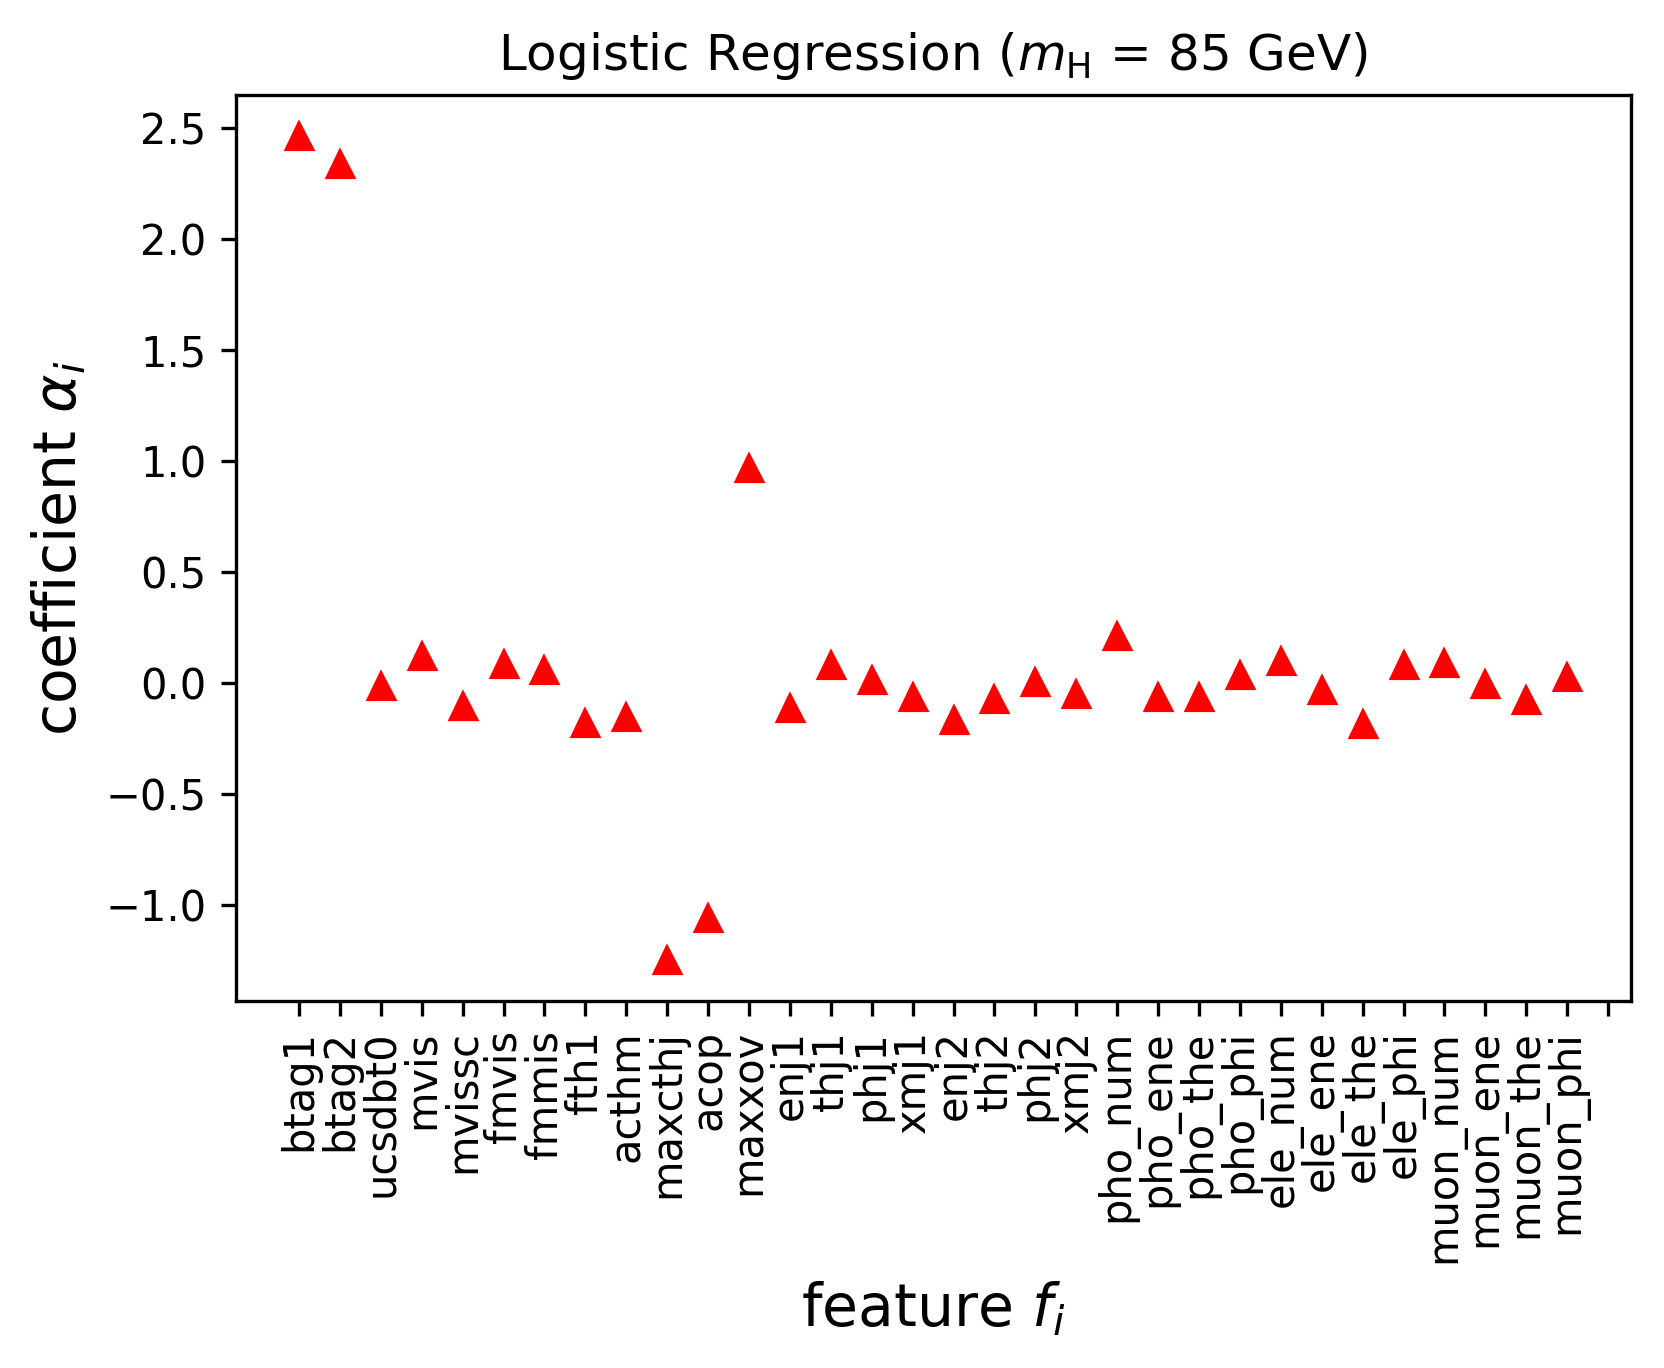

In [23]:
#plt.figure(figsize=(3,3))
plt.plot(logreg.coef_.T,'r^')
plt.title('Logistic Regression ($m_\mathrm{H}$ = 85 GeV)')
plt.ylabel(r'coefficient $\alpha_i$',fontsize=14)
plt.xlabel(r'feature $f_i$',fontsize=14)
#plt.plot(tree.coef_.T,'bo',label='tree')

plt.xticks(range(df_mH.shape[1]),X_train.columns,rotation=90)
plt.savefig("./plots/LogRegCoef")
plt.show()

In [67]:
coeflist = []
for l in logreg.coef_ :
    coeflist.append(l)
print coeflist

[array([ 1.665,  1.778,  0.019, -0.102, -0.014,  0.03 ,  0.016, -0.335,
        0.243, -1.119, -1.394,  0.482,  0.099,  0.502,  0.01 , -0.065,
        0.074,  0.187,  0.017, -0.042,  0.209, -0.039,  0.031, -0.024,
        0.438, -0.039, -0.255,  0.014, -0.267, -0.002, -0.056, -0.02 ])]


In [20]:
X_train.columns

Index([u'btag1', u'btag2', u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis',
       u'fth1', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1', u'thj1',
       u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2', u'pho_num',
       u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene', u'ele_the',
       u'ele_phi', u'muon_num', u'muon_ene', u'muon_the', u'muon_phi'],
      dtype='object')

In [19]:
coef_85 = np.array([ 0.313,  0.195,  0.284, -0.002, -0.031,  0.069, -0.019, -0.053,
       -0.173, -0.232, -0.295,  0.011,  0.004, -0.019,  0.009, -0.052,
       -0.033, -0.055, -0.003, -0.036,  0.106, -0.059, -0.006,  0.034,
        0.011, -0.027, -0.032,  0.057,  0.001, -0.003, -0.011,  0.024])

coef_90 = np.array([ 0.127,  0.184,  0.217, -0.043, -0.029, -0.016,  0.044, -0.046,
       -0.084, -0.149, -0.297,  0.002,  0.044,  0.051,  0.011, -0.049,
        0.039,  0.029,  0.012, -0.03 ,  0.072, -0.036,  0.03 , -0.001,
        0.053, -0.03 , -0.026,  0.028, -0.018, -0.004, -0.032, -0.046])

coef_95 = np.array([ 0.106,  0.048,  0.134, -0.091, -0.146,  0.059,  0.116,  0.008,
       -0.073, -0.094, -0.192, -0.001,  0.059,  0.021,  0.062, -0.023,
        0.039,  0.059,  0.018, -0.012,  0.035, -0.043,  0.069,  0.016,
       -0.002, -0.022,  0.001,  0.057,  0.006,  0.005,  0.013,  0.027])

In [37]:
coef_90_2 = np.array([ 0.158,  0.244,  0.335, -0.027, -0.078, -0.033,  0.115, -0.09 ,
       -0.047, -0.152, -0.198, -0.002, -0.   , -0.017, -0.01 , -0.023,
        0.035, -0.069, -0.048, -0.042,  0.11 , -0.004,  0.012,  0.022,
        0.009, -0.032, -0.026, -0.002, -0.024, -0.   , -0.02 , -0.14 ])

In [4]:
df_MC_noHiggs = pd.concat(framesMC_NoHiggs)
df_MC_mH85 = framesMC_HiggsModels[0]
df_mH85 = pd.concat([df_MC_noHiggs,framesMC_HiggsModels[0]])